# Process calcium imaging data with DataJoint Elements

This notebook will walk through processing two-photon calcium imaging data collected
from ScanImage and processed with Suite2p. While anyone can work through this
notebook to process calcium imaging data through DataJoint's
element-calcium-imaging pipeline, for a
detailed tutorial about the fundamentals of DataJoint including table types,
make functions, and querying, please see the DataJoint Tutorial.

The DataJoint Python API and Element Calcium Imaging offer a lot of features to support collaboration, automation, reproducibility, and visualizations.

For more information on these topics, please visit our documentation: 
 
- [DataJoint Core](https://datajoint.com/docs/core/): General principles

- DataJoint [Python](https://datajoint.com/docs/core/datajoint-python/) and
  [MATLAB](https://datajoint.com/docs/core/datajoint-matlab/) APIs: in-depth reviews of
  specifics

- [DataJoint Element Calcium Imaging](https://datajoint.com/docs/elements/element-calcium-imaging/):
  A modular pipeline for calcium imaging analysis

Let's start by importing the packages necessary to run this workflow. 

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

### The Basics:

Any DataJoint workflow can be broken down into basic 3 parts:

- `Insert`
- `Populate` (or process)
- `Query`

In this demo we will:
- `Insert` metadata about an animal subject, recording session, and 
  parameters related to processing calcium imaging data through Suite2p.
- `Populate` tables with outputs of image processing including motion correction,
  segmentation, mask classification, fluorescence traces and deconvolved activity traces.
- `Query` the processed data from the database and plot calcium activity traces.

Each of these topics will be explained thoroughly in this notebook.

### Workflow diagram

This workflow is assembled from 4 DataJoint elements:
+ [element-lab](https://github.com/datajoint/element-lab)
+ [element-animal](https://github.com/datajoint/element-animal)
+ [element-session](https://github.com/datajoint/element-session)
+ [element-calcium-imaging](https://github.com/datajoint/element-calcium-imaging)

Each element declares its own schema in the database. These schemas can be imported like
any other Python package. This workflow is composed of schemas from each of the Elements
above and correspond to a module within `workflow_calcium_imaging.pipeline`.

The schema diagram is a good reference for understanding the order of the tables
within the workflow, as well as the corresponding table type.
Let's activate the elements and view the schema diagram.

In [2]:
from workflow_calcium_imaging.pipeline import lab, subject, session, scan, imaging, Equipment, event, trial, analysis

[2023-03-17 22:30:23,259][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.
[2023-03-17 22:30:23,274][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-03-17 22:30:23,282][INFO]: Connected root@fakeservices.datajoint.io:3306


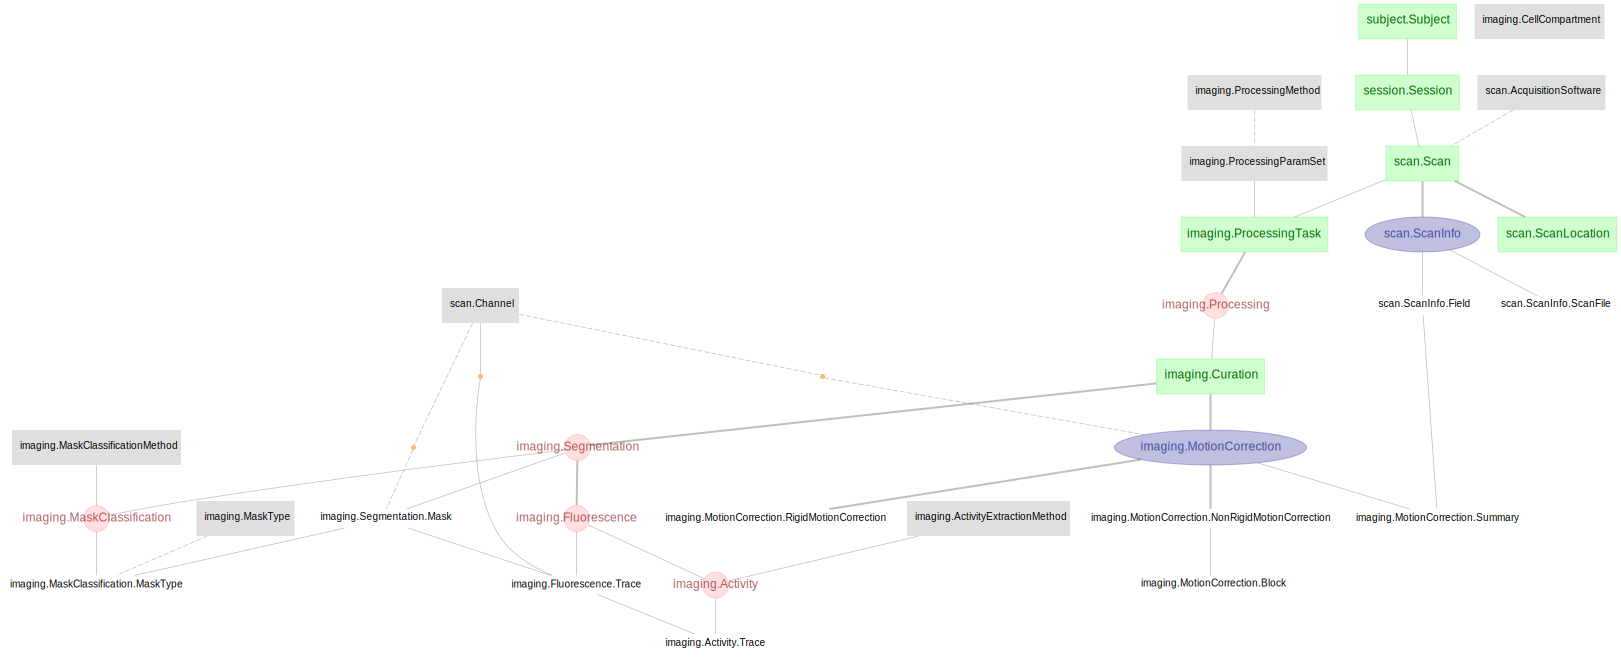

In [3]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan)
    + dj.Diagram(imaging)
)

### Diagram Breakdown

While the diagram above seems complex at first, it becomes more clear when it's
approached as a hierarchy of tables that **define the order** in which the workflow **expects to
receive data** in each of its tables. 

- Tables with a green, or rectangular shape expect to receive data manually using the
`insert()` function. 
- The tables higher up in the diagram such as `subject.Subject()`
should be the first to receive data. This ensures data integrity by preventing orphaned
data within DataJoint schemas. 
- Tables with a purple oval or red circle can be automatically filled with relevant data
  by calling `populate()`. For example `scan.ScanInfo` and its part-table
  `scan.ScanInfo.Field` are both populated with `scan.ScanInfo.populate()`.
- Tables connected by a solid line depend on attributes (entries) in the table
  above it

#### Table Types

There are 5 table types in DataJoint. Each of these appear in the diagram above.

- **Manual table**: green box, manually inserted table, expect new entries daily, e.g. Subject, ProbeInsertion.  
- **Lookup table**: gray box, pre inserted table, commonly used for general facts or parameters. e.g. Strain, ClusteringMethod, ClusteringParamSet.  
- **Imported table**: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. process of Clustering requires output files from kilosort2.  
- **Computed table**: red circle, auto-processing table, the processing does not depend on files external to the database, commonly used for     
- **Part table**: plain text, as an appendix to the master table, all the part
  entries of a given master entry represent a intact set of the master entry.
  e.g. Unit of a CuratedClustering.


## Starting the workflow: Insert

### Insert entries into manual tables

To view details about a table's dependencies and attributes, use functions `.describe()`
and `.heading`, respectively.

Let's start with the first table in the schema diagram (the `subject` table) and view
the table attributes we need to insert. There are two ways you can do this: *run each
of the two cells below*

In [4]:
subject.Subject.describe()

'subject              : varchar(8)                   \n---\nsubject_nickname=""  : varchar(64)                  \nsex                  : enum(\'M\',\'F\',\'U\')            \nsubject_birth_date   : date                         \nsubject_description="" : varchar(1024)                \n'

In [5]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table. These are particularly useful functions if you are new to
DataJoint Elements and are unsure of the attributes required for each table. We will insert data into the
`subject.Subject` table. 

In [6]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="ScanImage acquisition. Suite2p processing.",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,F,2020-01-01,ScanImage acquisition. Suite2p processing.


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`. 

In [7]:
session.Session.describe()

'-> subject.Subject\nsession_datetime     : datetime                     \n'

In [8]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 

The cells above show the dependencies and attributes for the `session.Session` table.
Notice that `describe` shows the dependencies of the table on upstream tables. The
`Session` table depends on the upstream `Subject` table. 

Whereas `heading` lists all the attributes of the `Session` table, regardless of
whether they are declared in an upstream table. 

Here we will demonstrate a very useful way of inserting data by assigning the dictionary
to a variable `session_key`. This variable can be used to insert entries into tables that
contain the `Session` table as one of its attributes.

In [9]:
session_key = dict(subject="subject1", session_datetime="2021-04-30 12:22:15.032")

session.Session.insert1(session_key)
session.Session()

subject,session_datetime
subject1,2021-04-30 12:22:15


The `SessionDirectory` table locates the relevant data files in a directory path
relative to the root directory defined in your `dj.config["custom"]`. More
information about `dj.config` is provided at the end of this tutorial and is
particularly useful for local deployments of this workflow.

In [10]:
session.SessionDirectory.describe()

'-> session.Session\n---\nsession_dir          : varchar(256)                 # Path to the data directory for a session\n'

In [11]:
session.SessionDirectory.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
---
session_dir          : varchar(256)                 # Path to the data directory for a session

In [12]:
session.SessionDirectory.insert1(
    dict(**session_key,
        session_dir="subject1/session1")
)
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-04-30 12:22:15,subject1/session1


Next, we'll use `describe` and `heading` for the Scan table. Do you notice anything we
might have missed here? 

In [13]:
scan.Scan.describe()

'-> session.Session\nscan_id              : int                          \n---\n-> [nullable] Equipment\n-> scan.AcquisitionSoftware\nscan_notes=""        : varchar(4095)                \n'

In [ ]:
scan.Scan.heading

The `Scan` table's attributes include the `Session` table **and** the `Equipment` table.
Let's insert into the Equipment table after checking its attributes. Then, we will
insert into `Scan`.

In [14]:
Equipment.insert1(dict(scanner="ScannerA"))

In [15]:
scan.Scan.insert1(
    dict(
        **session_key,
        scan_id=0,
        scanner="ScannerA",
        acq_software="ScanImage",
        scan_notes="",
    )
)
scan.Scan()

subject,session_datetime,scan_id,scanner,acq_software,scan_notes
subject1,2021-04-30 12:22:15,0,ScannerA,ScanImage,


## Populate

### Automatically populate tables

`scan.ScanInfo` is the first table in the pipeline that can be populated automatically.
If a table contains a part table, this part table is also populated during the
`populate()` call. `populate()` takes several arguments including the a session
key. This key restricts `populate()` to performing the operation on the session
of interest rather than all possible sessions which could be a time-intensive
process for databases with lots of entries.

Let's view the `scan.ScanInfo` and its part table
`scan.ScanInfo.Field` and populate both through a single `populate()` call.

In [16]:
scan.ScanInfo.heading

# General data about the resoscans/mesoscans from header
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : flo

In [17]:
scan.ScanInfo.Field.heading

# field-specific scan information
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
field_idx            : int                          # 
---
px_height            : smallint                     # height in pixels
px_width             : smallint                     # width in pixels
um_height=null       : float                        # height in microns
um_width=null        : float                        # width in microns
field_x=null         : float                        # (um) center of field in the motor coordinate system
field_y=null         : float                        # (um) center of field in the motor coordinate system
field_z=null         : float                        # (um) relative depth of field
delay_image=null     : longblob                     # (ms) delay between the start of the scan and pixels in this field
roi=null             : int                 

In [18]:
scan.ScanInfo()

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan


In [19]:
scan.ScanInfo.Field()

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans


In [20]:
# duration depends on your network bandwidth to s3
scan.ScanInfo.populate(session_key, display_progress=True)

ScanInfo: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Let's view the information was entered into each of these tables:

In [21]:
scan.ScanInfo()

subject,session_datetime,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan,bidirectional_z true = bidirectional z-scan
subject1,2021-04-30 12:22:15,0,1,1,1,3000,0,13441.9,15745.0,-205821.0,29.2398,1,63.0981,0.712867,None,102.6,None


In [22]:
scan.ScanInfo.Field()

subject,session_datetime,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
subject1,2021-04-30 12:22:15,0,0,512,512,nan,nan,13441.9,15745.0,-205821.0,=BLOB=,None


We're almost ready to perform image processing with `Suite2p`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
import suite2p and insert the default parameters into a DataJoint table
`ProcessingParamSet`. This table keeps track of all combinations of your image processing
parameters. You can choose which parameters are used during processing in a later step.

Let's view the attributes and insert data into `imaging.ProcessingParamSet`.

In [23]:
imaging.ProcessingParamSet.heading

# Processing Parameter Set
paramset_idx         : smallint                     # Unique parameter set ID.
---
processing_method    : char(8)                      # 
paramset_desc        : varchar(1280)                # Parameter-set description
param_set_hash       : uuid                         # A universally unique identifier for the parameter set
params               : longblob                     # Parameter Set, a dictionary of all applicable parameters to the analysis suite.

In [24]:
import suite2p

params_suite2p = suite2p.default_ops()
params_suite2p['nonrigid']=False

imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=0,
    params=params_suite2p,
    paramset_desc="Calcium imaging analysis with Suite2p using default Suite2p parameters",
)

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


Now that we've inserted suite2p parameters into the `ProcessingParamSet` table,
we're almost ready to run image processing. DataJoint uses a `ProcessingTask` table to
manage which `Scan` and `ProcessingParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [25]:
imaging.ProcessingTask.describe()

'# Manual table for defining a processing task ready to be run\n-> scan.Scan\n-> imaging.ProcessingParamSet\n---\nprocessing_output_dir : varchar(255)                 # Output directory of the processed scan relative to root data directory\ntask_mode="load"     : enum(\'load\',\'trigger\')       # \'load\': load computed analysis results, \'trigger\': trigger computation\n'

In [26]:
imaging.ProcessingTask.heading

# Manual table for defining a processing task ready to be run
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
paramset_idx         : smallint                     # Unique parameter set ID.
---
processing_output_dir : varchar(255)                 # Output directory of the processed scan relative to root data directory
task_mode="load"     : enum('load','trigger')       # 'load': load computed analysis results, 'trigger': trigger computation

The `ProcessingParamSet` table contains two important attributes: 
+ `paramset_idx` 
+ `task_mode` 

The `paramset_idx` attribute is tracks
your image processing parameter sets. You can choose the parameter set on which
you want to run image processing analysis based on this attribute. For example,
`paramset_idx=0` may contain default parameters for suite2p processing whereas
`paramset_idx=1` contains your custom parameters for suite2p processing. This
attribute tells the `Processing` table which set of parameters you are
processing in a given `populate()`.

The `task_mode` attribute can be set to either `load` or `trigger`. When set to `load`,
running the processing step initiates a search for exisiting output files of the image
processing algorithm defined in `ProcessingParamSet`. When set to `trigger`, the
processing step will run image processing on the raw data. 

In [27]:
imaging.ProcessingTask.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=0,
        task_mode='load', # load or trigger
        processing_output_dir="subject1/session1/suite2p",
    )
)

Notice we are setting `task_mode` to `load`. Let's call populate on the `Processing`
table in the pipeline. 

In [28]:
imaging.Processing.populate(session_key, display_progress=True)

Processing: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]


While processing is complete in the step above, you can optionally curate the output of
image processing using the `Curation` table.

In [29]:
imaging.Curation.heading

# Curation(s) results
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
scan_id              : int                          # 
paramset_idx         : smallint                     # Unique parameter set ID.
curation_id          : int                          # 
---
curation_time        : datetime                     # Time of generation of this set of curated results
curation_output_dir  : varchar(255)                 # Output directory of the curated results, relative to root data directory
manual_curation      : tinyint                      # Has manual curation been performed on this result?
curation_note=""     : varchar(2000)                # 

In [30]:
imaging.Curation.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=0,
        curation_id=0,
        curation_time="2021-04-30 12:22:15.032",
        curation_output_dir="subject1/session1/suite2p",
        manual_curation=False,
        curation_note="",
    )
)

Now, we'll populate several tables that store the output of image processing, including
`MotionCorrection`, `Segementation`, `Fluorescence`, and `Activity`.

Feel free to create new cells in this notebook to view each table's dependencies and
attributes. 

In [31]:
imaging.MotionCorrection.populate(session_key, display_progress=True)

MotionCorrection: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


In [32]:
imaging.Segmentation.populate(session_key, display_progress=True)

Segmentation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [33]:
imaging.Fluorescence.populate(session_key, display_progress=True)

Fluorescence: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


In [34]:
imaging.Activity.populate(session_key, display_progress=True)

Activity: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Now that we've populated the tables in this workflow, there are one of
several options for next steps. If you have a standard workflow for
aligning calcium activity to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

In this tutorial, we will fetch the data from the database and create a few plots.

## Query

This section focuses on working with data that is already in the
database. 

DataJoint queries allow you to view and import data from the database into a python
variable using the `fetch()` method. 

There are several important features supported by `fetch()`:
- By default, an empty `fetch()` imports a list of dictionaries containing all
  attributes of all entries in the table that is queried.
- **`fetch1()`**, on the other hand, imports a dictionary containing all attributes of
  one of the entries in the table. By default, if a table has multiple entries,
  `fetch1()` imports the first entry in the table.
- Both `fetch()` and `fetch1()` accept table attributes as an argument to query
  that particular attribute. For example `fetch1('fps')` will fetch the first
  value of the `fps` attribute if it exists in the table.
- Recommended best practice is to **restrict** queries by primary key attributes of the
  table to ensure the accuracy of imported data.
    - The most common restriction for entries in DataJoint tables is performed
      using the `&` operator. For example to fetch all session start times belonging to
      `subject1`, a possible query could be `subject1_sessions =
      (session.Session & "subject = 'subject1'").fetch("session_datetime")`.  
- `fetch()` can also be used to obtain the primary keys of a table. To fetch the primary
  keys of a table use `<table_name>.fetch("KEY")` syntax.

Let's walk through these concepts of querying by moving from simple to more
complex queries.

In [35]:
fluor_trace = (imaging.Fluorescence.Trace & "mask = '10'").fetch1("fluorescence")

In the query above, we fetch a single `fluorescence` attribute from the `Trace` part
table belonging to the `Fluorescence` table. We also restrict the query to mask
number 10. 

Let's go ahead and plot this trace.

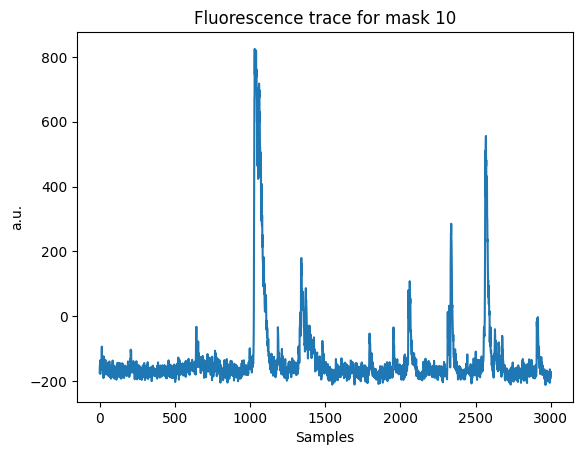

In [36]:
plt.plot(fluor_trace)
plt.title("Fluorescence trace for mask 10");
plt.xlabel("Samples")
plt.ylabel("a.u.");

DataJoint queries can be a highly flexible tool to manipulate and visualize your data.
After all, plotting traces is likely just the start of your analysis workflow. This can
also make the queries seem more complex at first. However, we'll walk through them
slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries: 
- Use **multiple restrictions** to fetch one image into the variable `average_image`.
- Use a **join** operation and **multiple restrictions** to fetch mask coordinates from
  `imaging.Segmentation.Mask` and overlay these with the average image.

In [37]:
average_image = (
    imaging.MotionCorrection.Summary & session_key & "field_idx=0"
).fetch1("average_image")

The query above restricts the `average_image` attribute of the `Summary` part
table of the `MotionCorrection` table by the `session_key` variable containing primary
key attributes of the current session and the `field_idx` attribute of the
`Summary` table. 

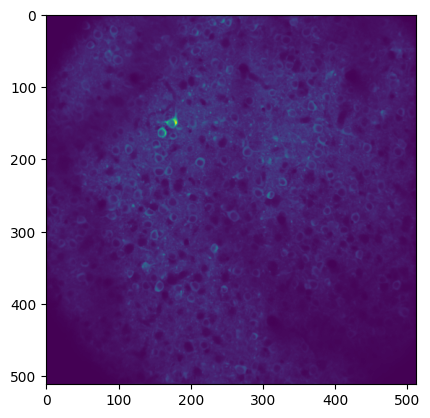

In [38]:
plt.imshow(average_image)

The next query introduces the **join** feature of DataJoint queries. DataJoint
tables can be joined to combine their primary key attributes and display the
attributes of all the tables. It also performs 3 restrictions with the `&`
operator and simultaneously fetches the contents of 2 different attributes to
two different variables.

Let's see the full query and then build it up one step at a time: 
```python
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & session_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")
```

This query joins `imaging.Segmentation.Mask` with `imaging.MaskClassification.MaskType`.
Below we will: 

1. See the contents of each table individually.
2. See the contents of the two tables joined together without restrictions.
3. See the contents of the two tables with the restrictions.
4. Execute the query to fetch the data.

In [39]:
imaging.Segmentation.Mask()

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
subject1,2021-04-30 12:22:15,0,0,0,0,0,305,176,149,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,1,0,177,156,377,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,2,0,187,160,165,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,3,0,208,48,285,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,4,0,153,148,305,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,5,0,247,256,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,6,0,146,104,261,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,7,0,413,276,189,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,8,0,223,92,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
subject1,2021-04-30 12:22:15,0,0,0,9,0,150,340,9,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [40]:
imaging.MaskClassification.MaskType()

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask_classification_method,mask,mask_type,confidence
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,0,soma,0.81364
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,1,soma,0.850127
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,2,soma,0.747744
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,3,soma,0.856031
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,4,soma,0.985041
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,5,soma,0.825305
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,6,soma,0.99609
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,7,soma,0.947971
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,8,soma,0.963464
subject1,2021-04-30 12:22:15,0,0,0,suite2p_default_classifier,9,soma,0.913962


In [41]:
imaging.Segmentation.Mask * imaging.MaskClassification.MaskType

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,mask_classification_method,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above,mask_type,confidence
subject1,2021-04-30 12:22:15,0,0,0,0,suite2p_default_classifier,0,305,176,149,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.81364
subject1,2021-04-30 12:22:15,0,0,0,1,suite2p_default_classifier,0,177,156,377,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.850127
subject1,2021-04-30 12:22:15,0,0,0,2,suite2p_default_classifier,0,187,160,165,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.747744
subject1,2021-04-30 12:22:15,0,0,0,3,suite2p_default_classifier,0,208,48,285,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.856031
subject1,2021-04-30 12:22:15,0,0,0,4,suite2p_default_classifier,0,153,148,305,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.985041
subject1,2021-04-30 12:22:15,0,0,0,5,suite2p_default_classifier,0,247,256,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.825305
subject1,2021-04-30 12:22:15,0,0,0,6,suite2p_default_classifier,0,146,104,261,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.99609
subject1,2021-04-30 12:22:15,0,0,0,7,suite2p_default_classifier,0,413,276,189,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.947971
subject1,2021-04-30 12:22:15,0,0,0,8,suite2p_default_classifier,0,223,92,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.963464
subject1,2021-04-30 12:22:15,0,0,0,9,suite2p_default_classifier,0,150,340,9,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.913962


In [42]:
(
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & session_key
    & "mask_center_z=0"
    & "mask_npix > 130"
)

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,mask_classification_method,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above,mask_type,confidence
subject1,2021-04-30 12:22:15,0,0,0,0,suite2p_default_classifier,0,305,176,149,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.81364
subject1,2021-04-30 12:22:15,0,0,0,1,suite2p_default_classifier,0,177,156,377,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.850127
subject1,2021-04-30 12:22:15,0,0,0,2,suite2p_default_classifier,0,187,160,165,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.747744
subject1,2021-04-30 12:22:15,0,0,0,3,suite2p_default_classifier,0,208,48,285,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.856031
subject1,2021-04-30 12:22:15,0,0,0,4,suite2p_default_classifier,0,153,148,305,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.985041
subject1,2021-04-30 12:22:15,0,0,0,5,suite2p_default_classifier,0,247,256,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.825305
subject1,2021-04-30 12:22:15,0,0,0,6,suite2p_default_classifier,0,146,104,261,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.99609
subject1,2021-04-30 12:22:15,0,0,0,7,suite2p_default_classifier,0,413,276,189,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.947971
subject1,2021-04-30 12:22:15,0,0,0,8,suite2p_default_classifier,0,223,92,277,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.963464
subject1,2021-04-30 12:22:15,0,0,0,9,suite2p_default_classifier,0,150,340,9,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,soma,0.913962


In [43]:
mask_xpix, mask_ypix = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & session_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).fetch("mask_xpix", "mask_ypix")

Using this query, we've fetched the coordinates of segmented masks. We can overlay these
masks onto our average image.

In [44]:
mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

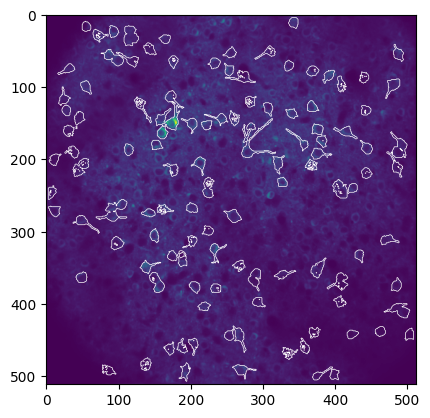

In [45]:
plt.imshow(average_image)
plt.contour(mask_image, colors="white", linewidths=0.5);

One more example using queries - plot fluorescence and deconvolved activity
traces:

Here we fetch the primary key attributes of the entry with `curation_id=0` for the
current session in the `imaging.Curation` table. 

Then, we fetch all cells that fit the
restriction criteria from `imaging.Segmentation.Mask` and
`imaging.MaskClassification.MaskType` as a `projection`. 

We then use this projection as
a restriction to fetch and plot fluorescence and deconvolved activity traces from the
`imaging.Fluorescence.Trace` and `imaging.Activity.Trace` tables, respectively.

In [46]:
curation_key = (imaging.Curation & session_key & "curation_id=0").fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 130"
).proj()

query_cells

subject,session_datetime,scan_id,paramset_idx Unique parameter set ID.,curation_id,mask,mask_classification_method
subject1,2021-04-30 12:22:15,0,0,0,0,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,1,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,2,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,3,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,4,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,5,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,6,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,7,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,8,suite2p_default_classifier
subject1,2021-04-30 12:22:15,0,0,0,9,suite2p_default_classifier


In [47]:
fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

activity_traces = (imaging.Activity.Trace & query_cells).fetch(
    "activity_trace", order_by="mask"
)

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

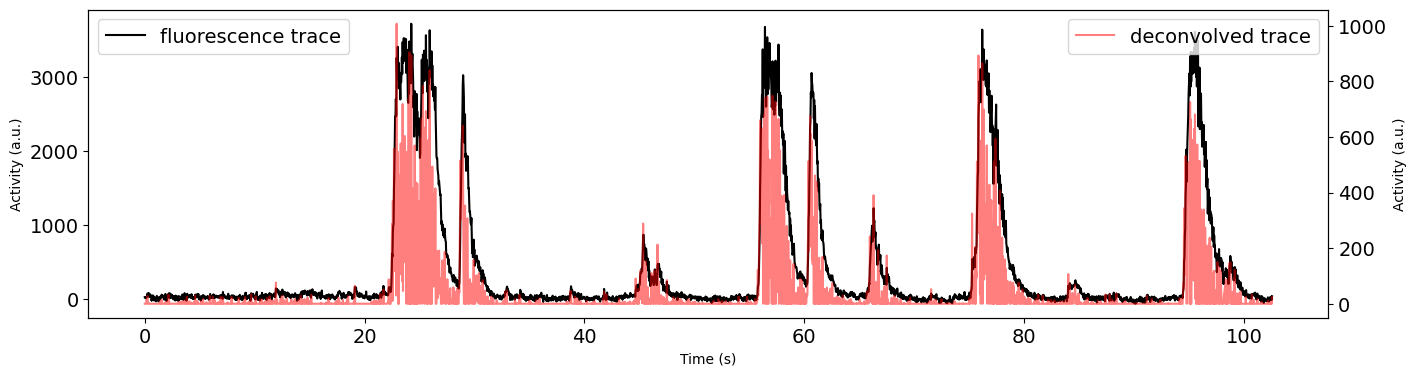

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[: f.size] * 1 / sampling_rate, f, "k", label="fluorescence trace")
    ax2.plot(
        np.r_[: a.size] * 1 / sampling_rate,
        a,
        "r",
        alpha=0.5,
        label="deconvolved trace",
    )

    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax.legend(loc="upper left", prop={"size": 14})
ax2.legend(loc="upper right", prop={"size": 14})

ax.set_xlabel("Time (s)")
ax.set_ylabel("Activity (a.u.)")
ax2.set_ylabel("Activity (a.u.)");